# Spotify API Experiments

https://developer.spotify.com/community

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

# Spotify Credentials
import spot_creds

# Graphing
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.feature_extraction.text import TfidfVectorizer

clid = spot_creds.client_id
secret = spot_creds.secret


In [2]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=clid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Get Songs from Playlist
Using my "Tom's Funky Jazz Group" playlist.

In [3]:
# playlist_link = "https://open.spotify.com/playlist/1jAT4AEQab8P4Qg1olncPw" # Tom's Funky Jazz Group
playlist_link = "https://open.spotify.com/playlist/7eWWLoTfmLUcD0viBP6Hr0?si=e8b0760749404749" #Funky Songs
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [4]:
# sp.playlist_tracks(playlist_URI)

In [5]:
first_track = sp.playlist_tracks(playlist_URI)["items"][0]

In [6]:
first_track

{'added_at': '2020-10-21T17:21:52Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/12100945354'},
  'href': 'https://api.spotify.com/v1/users/12100945354',
  'id': '12100945354',
  'type': 'user',
  'uri': 'spotify:user:12100945354'},
 'is_local': False,
 'primary_color': None,
 'track': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2pXFmyqPm7wHJ1HGAwyR3L'},
     'href': 'https://api.spotify.com/v1/artists/2pXFmyqPm7wHJ1HGAwyR3L',
     'id': '2pXFmyqPm7wHJ1HGAwyR3L',
     'name': 'Here Come The Mummies',
     'type': 'artist',
     'uri': 'spotify:artist:2pXFmyqPm7wHJ1HGAwyR3L'}],
   'available_markets': [],
   'external_urls': {'spotify': 'https://open.spotify.com/album/5qkp95o3LcCOpo4rQddh3n'},
   'href': 'https://api.spotify.com/v1/albums/5qkp95o3LcCOpo4rQddh3n',
   'id': '5qkp95o3LcCOpo4rQddh3n',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab67616d0000b2730c4072e9a5c

In [7]:
def extract_audio_feat(track_uri, track_dict):
        # Audio Features
    audio_feat_list = ['acousticness',
                       'danceability',
                       'energy',
                       'instrumentalness',
                       'key',
                       'liveness',
                       'loudness',
                       'mode',
                       'speechiness',
                       'tempo',
                       'time_signature',
                       'valence']
                       
    audio_feat = sp.audio_features(track_uri)[0]
    
    audio_feat_list = ['acousticness',
                       'danceability',
                       'energy',
                       'instrumentalness',
                       'key',
                       'liveness',
                       'loudness',
                       'mode',
                       'speechiness',
                       'tempo',
                       'time_signature',
                       'valence']
    
    for feat in audio_feat_list:
        track_dict[feat] = audio_feat[feat]
        
    return track_dict

In [8]:
tracks_df = pd.DataFrame()

for track in sp.playlist_tracks(playlist_URI)["items"]:
    this_track = {}
    #URI
    track_uri = track["track"]["uri"]
    this_track['track_uri'] = track_uri
    
    #Track name
    this_track['track_name'] = track["track"]["name"]
    
    #Main Artist
    artist_uri = track["track"]["artists"][0]["uri"]
    this_track['artist_uri'] = artist_uri
    artist_info = sp.artist(artist_uri)
    
    #Name, popularity, genre
    this_track['artist_name'] = track["track"]["artists"][0]["name"]
    this_track['artist_pop'] = artist_info["popularity"]
    this_track['artist_genres'] = artist_info["genres"]
    
    #Album
    this_track['album'] = track["track"]["album"]["name"]
    
    #Track Metadata
    this_track['track_pop'] = track["track"]["popularity"]
    this_track['explicit'] = track["track"]['explicit']
    
    # Audio Features
    this_track = extract_audio_feat(track_uri, this_track)
    
    
# Convert to DataFrame
    this_track_df = pd.json_normalize(this_track)
    
    tracks_df = pd.concat([tracks_df,this_track_df], ignore_index=True)
    
    # Make sure there are no duplicates
    tracks_df = tracks_df.drop_duplicates('track_uri')
    
tracks_df.head()

,track_uri,track_name,artist_uri,artist_name,artist_pop,artist_genres,album,track_pop,explicit,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,spotify:track:5ZDLCdSHmpt2JKwWmotjzG,Pants,spotify:artist:2pXFmyqPm7wHJ1HGAwyR3L,Here Come The Mummies,35,[funk rock],Single Entendre,0,False,0.02650,...,0.851,0.000000,1,0.3580,-4.067,0,0.0351,123.910,4,0.809
1,spotify:track:6NBqMK4DfBYGIzCnmSgliG,Dirty Minds,spotify:artist:2pXFmyqPm7wHJ1HGAwyR3L,Here Come The Mummies,35,[funk rock],Everlasting Party,0,False,0.00999,...,0.832,0.000000,9,0.0902,-5.705,1,0.0605,132.901,4,0.878
2,spotify:track:4zxXklp6D4vClyC08SUeo9,Carnal Carnival,spotify:artist:2pXFmyqPm7wHJ1HGAwyR3L,Here Come The Mummies,35,[funk rock],Carnal Carnival,0,False,0.44300,...,0.934,0.000000,11,0.6820,-3.049,0,0.0708,160.061,4,0.753
3,spotify:track:3qaO2Ko1b0bBisqNLU1e1s,Freak Flag,spotify:artist:2pXFmyqPm7wHJ1HGAwyR3L,Here Come The Mummies,35,[funk rock],Carnal Carnival,0,False,0.03550,...,0.901,0.000000,1,0.3740,-3.393,1,0.0452,109.968,4,0.830
4,spotify:track:6zADCSrbXuHSTnZbznyyY9,Live in the Moment,spotify:artist:2pXFmyqPm7wHJ1HGAwyR3L,Here Come The Mummies,35,[funk rock],Live in the Moment,0,False,0.00324,...,0.753,0.000215,1,0.1740,-6.065,0,0.0329,105.947,4,0.502


In [9]:
tracks_df.loc[tracks_df.explicit==True]

,track_uri,track_name,artist_uri,artist_name,artist_pop,artist_genres,album,track_pop,explicit,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
14,spotify:track:1SLL7e838eRBZVlMakDjfU,Little Red Corvette - 2019 Remaster,spotify:artist:5a2EaR3hamoenG9rDuVn8j,Prince,71,"[funk, funk rock, minneapolis sound, rock, syn...",1999 (Super Deluxe Edition),26,True,0.1640,...,0.858,0.000098,1,0.4590,-6.054,1,0.0978,122.974,4,0.658
74,spotify:track:3DqvBu9MpNNz4UToUXDJ4u,Sexy M.F.,spotify:artist:5a2EaR3hamoenG9rDuVn8j,Prince,71,"[funk, funk rock, minneapolis sound, rock, syn...",[Love Symbol],44,True,0.1690,...,0.744,0.002230,2,0.0537,-8.133,1,0.0937,106.150,4,0.548
75,spotify:track:7abnSqcxNsfCYvC1neBXrR,The Sacrifice of Victor,spotify:artist:5a2EaR3hamoenG9rDuVn8j,Prince,71,"[funk, funk rock, minneapolis sound, rock, syn...",[Love Symbol],17,True,0.0738,...,0.936,0.000025,1,0.1740,-4.008,1,0.1090,104.171,4,0.530
76,spotify:track:4JUgmt3hxaO5gLXq4puZKK,Sexy M.F.,spotify:artist:5a2EaR3hamoenG9rDuVn8j,Prince,71,"[funk, funk rock, minneapolis sound, rock, syn...",[Love Symbol],43,True,0.1690,...,0.744,0.002240,2,0.0537,-8.133,1,0.0938,106.147,4,0.547


In [11]:
genres_df = pd.DataFrame(
        pd.DataFrame(tracks_df.artist_genres.tolist())[0].tolist(), index=tracks_df.track_name
)
genres_df.columns=['genre']
genres_df.reset_index(inplace=True)
genres_df.head()

,track_name,genre
0,Pants,funk rock
1,Dirty Minds,funk rock
2,Carnal Carnival,funk rock
3,Freak Flag,funk rock
4,Live in the Moment,funk rock


<AxesSubplot:>

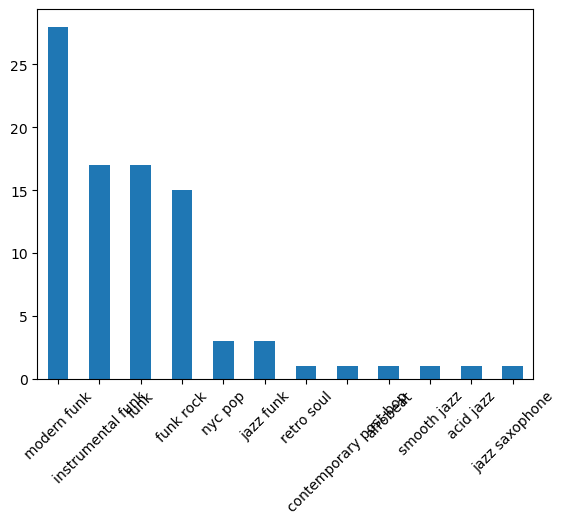

In [12]:
genres_df.genre.value_counts().plot(kind='bar', rot=45)

In [13]:
tracks_df.artist_name.value_counts()

Here Come The Mummies            15
Santa Fe & The Fat City Horns    14
Tower Of Power                   12
Home Cookin'                     10
Phat Phunktion                    8
Cory Wong                         8
Philip Lassiter                   6
Mingo Fishtrap                    6
Prince                            5
Lawrence                          3
David Sanborn                     2
Incognito                         1
The Jazz Crusaders                1
Candy Dulfer                      1
Tom McGuire & the Brassholes      1
The Fearless Flyers               1
Orgone                            1
Thomas Atlas                      1
MF Robots                         1
Jaco Pastorius                    1
Sister Sparrow                    1
Maceo Parker                      1
Name: artist_name, dtype: int64

## Audio Features

In [14]:
tracks_df.iloc[0]

track_uri            spotify:track:5ZDLCdSHmpt2JKwWmotjzG
track_name                                          Pants
artist_uri          spotify:artist:2pXFmyqPm7wHJ1HGAwyR3L
artist_name                         Here Come The Mummies
artist_pop                                             35
artist_genres                                 [funk rock]
album                                     Single Entendre
track_pop                                               0
explicit                                            False
acousticness                                       0.0265
danceability                                        0.663
energy                                              0.851
instrumentalness                                      0.0
key                                                     1
liveness                                            0.358
loudness                                           -4.067
mode                                                    0
speechiness   

In [15]:
track_uri = tracks_df.iloc[1]['track_uri']
audio_feat = sp.audio_features(track_uri)
audio_feat

[{'danceability': 0.603,
  'energy': 0.832,
  'key': 9,
  'loudness': -5.705,
  'mode': 1,
  'speechiness': 0.0605,
  'acousticness': 0.00999,
  'instrumentalness': 0,
  'liveness': 0.0902,
  'valence': 0.878,
  'tempo': 132.901,
  'type': 'audio_features',
  'id': '6NBqMK4DfBYGIzCnmSgliG',
  'uri': 'spotify:track:6NBqMK4DfBYGIzCnmSgliG',
  'track_href': 'https://api.spotify.com/v1/tracks/6NBqMK4DfBYGIzCnmSgliG',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6NBqMK4DfBYGIzCnmSgliG',
  'duration_ms': 267160,
  'time_signature': 4}]

In [16]:
audio_feat[0]['danceability']

0.603

In [17]:
# sp.audio_analysis(track_uri)

In [18]:
tracks_df.describe()

,artist_pop,track_pop,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,33.410000,16.940000,0.141408,0.672280,0.776240,0.120686,5.400000,0.235843,-6.499500,0.610000,0.087910,119.275460,3.940000,0.728826
std,17.696142,15.048622,0.171117,0.115555,0.154608,0.273114,3.559026,0.219329,2.175421,0.490207,0.050447,28.540604,0.342893,0.166630
min,0.000000,0.000000,0.000706,0.341000,0.000020,0.000000,0.000000,0.009300,-12.221000,0.000000,0.023900,62.020000,1.000000,0.079600
25%,23.000000,0.000000,0.025825,0.596750,0.704500,0.000001,2.000000,0.079075,-8.145750,0.000000,0.054775,102.753250,4.000000,0.656500
50%,35.000000,14.500000,0.070900,0.696000,0.815000,0.000226,5.500000,0.150500,-6.436500,1.000000,0.074750,109.965500,4.000000,0.767500
75%,48.000000,26.250000,0.182500,0.758000,0.887250,0.007370,9.000000,0.316500,-4.701000,1.000000,0.111250,125.177000,4.000000,0.834000
max,71.000000,54.000000,0.852000,0.918000,0.972000,0.908000,11.000000,0.953000,-1.840000,1.000000,0.315000,201.985000,4.000000,0.966000


## Features

### Meta Data

In [ ]:
def ohe_prep(df, column, new_name): 
    ''' 
    Create One Hot Encoded features of a specific column
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
    column (str): Column to be processed
    new_name (str): new column name to be used
        
    Output: 
    tf_df: One-hot encoded features 
    '''
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df



In [ ]:
# TF-IDF implementation
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(tracks_df['artist_genres'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
# genre_df.drop(columns='genre|unknown') # Drop unknown genre
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

In [ ]:
list(genre_df.columns)

In [20]:
# normalize popularity
tracks_df['artist_pop'] = tracks_df['artist_pop']/100
tracks_df['track_pop'] = tracks_df['track_pop']/100
